In [1]:
from DataFetcher import DataFetcher
from USTs import USTs
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime

In [2]:
auctions = DataFetcher().fetch_auction_data()
prices = DataFetcher().fetch_historical_UST_data(date=datetime(year=2025, month=6, day=17))

In [3]:
ust_set = USTs(auction_data=auctions, price_data=prices, discount_curve=None).get_current_UST_set()

Merged auction and price data successfully
No missing or excess data
All CUSIPs are identical between DataFrames


In [7]:
ust_set

,Cusip,Security type,Rate,Maturity date,Buy,Sell,End of day,security_term,auction_date
0,912797NV5,Bill,0.000,2025-06-20,0.000000,99.964750,99.976500,26-Week,2024-12-16
1,912797PT8,Bill,0.000,2025-06-24,99.919500,99.919111,99.930500,17-Week,2025-02-19
2,912797NW3,Bill,0.000,2025-06-26,99.896500,99.896000,99.907778,26-Week,2024-12-23
3,912797PU5,Bill,0.000,2025-07-01,99.838417,99.837833,99.849778,17-Week,2025-02-26
4,912797NX1,Bill,0.000,2025-07-03,99.815556,99.815111,99.826667,26-Week,2024-12-30
...,...,...,...,...,...,...,...,...,...
453,91282CKM2,FRN,4.497,2026-04-30,100.063279,100.037539,100.046116,2-Year,2024-04-24
454,91282CLA7,FRN,4.529,2026-07-31,100.095285,100.076009,100.084269,2-Year,2024-07-24
455,91282CLT6,FRN,4.553,2026-10-31,100.137565,100.114073,100.134206,2-Year,2024-10-29
456,91282CMJ7,FRN,4.444,2027-01-31,99.981891,99.942419,99.982671,2-Year,2025-01-28


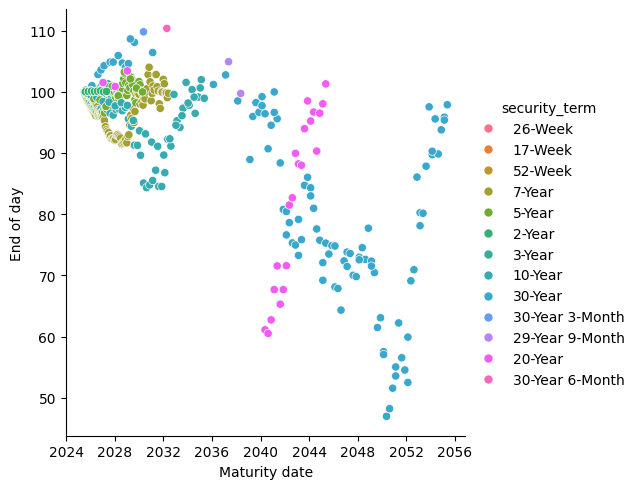

In [5]:
sns.relplot(data=ust_set, x='Maturity date', y='End of day', hue='security_term', kind='scatter')

In [9]:
usts = USTs(auction_data=auctions, price_data=None, discount_curve=None)
otr = usts.get_nth_OTRs(10)
otr

,cusip,auction_date,security_term,avg_med_yield,maturity_date,run
0,91282CNL1,2025-06-24,2-Year,NaN,2027-06-30,1
1,91282CNE7,2025-05-27,2-Year,3.900,2027-05-31,2
2,91282CMX6,2025-04-23,2-Year,NaN,2027-04-30,3
3,91282CMY4,2025-04-22,2-Year,3.740,2027-04-30,4
4,91282CMV0,2025-03-25,2-Year,3.936,2027-03-31,5
...,...,...,...,...,...,...
65,912810UA4,2024-05-09,30-Year,4.585,2054-05-15,6
66,912810TY4,2024-02-22,30-Year,2.107,2054-02-15,7
67,912810TX6,2024-02-08,30-Year,4.314,2054-02-15,8
68,912810TV0,2023-11-09,30-Year,4.650,2053-11-15,9


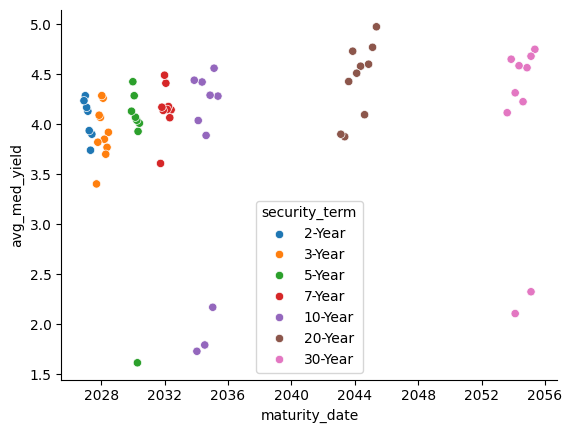

In [10]:
plt.Figure(figsize=(30,10))
sns.scatterplot(data=otr, x='maturity_date', y='avg_med_yield', hue='security_term')
sns.despine()